In [54]:
from rdkit import Chem
import pandas as pd

In [55]:
df = pd.read_csv("zhang_test.csv")

In [56]:
def out_sdf(lig_list, filename):
    writer = Chem.SDWriter(filename)
    for i in lig_list:
        writer.write(i)
    writer.close()
    return

In [57]:
cpd_list = []
for idx, row in df.iterrows():
    if idx % 5000 == 0:
        print(idx, 'have been processed')
    try:
        smi = row['SMILES']
        mol = Chem.MolFromSmiles(smi)
        for prop in df.columns:
            prop_value = str(row[prop])
            mol.SetProp(prop, prop_value)
    except Exception as e:
        print(idx, e)
    cpd_list.append(mol)
len(cpd_list)

0 have been processed


533

In [58]:
out_sdf(cpd_list, '2c8.sdf')

In [59]:
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from sklearn.model_selection import train_test_split

In [60]:
fname = '2c8.sdf'

In [61]:
mols = []
y = []
for mol in Chem.SDMolSupplier(fname):
    mols.append(mol)
    y.append(mol.GetIntProp('CLASS'))

In [62]:
seed = 42

In [96]:
x_trainval_mol, x_test_mol, y_trainval, y_test = train_test_split(mols, y, test_size=0.2, random_state=seed)

In [97]:
x_train_mol, x_valid_mol, y_train, y_valid = train_test_split(x_trainval_mol, y_trainval, test_size=0.2, random_state=seed)

In [1579]:
len(x_train_mol)

340

In [99]:
len(x_test_mol)

107

In [100]:
len(x_valid_mol)

86

In [101]:
def mol_to_smiles(mols):
    smiles = []
    for mol in mols:
        s = Chem.MolToSmiles(mol)
        smiles.append(s)
    return np.asarray(smiles)

In [102]:
x_train_smiles = mol_to_smiles(x_train_mol)

In [104]:
x_test_smiles = mol_to_smiles(x_test_mol)

In [105]:
x_valid_smiles = mol_to_smiles(x_valid_mol)

In [108]:
fp1 = [AllChem.GetMorganFingerprintAsBitVect(m1, 2) for m1 in x_train_mol]

In [110]:
fp2 = [AllChem.GetMorganFingerprintAsBitVect(m2, 2) for m2 in x_test_mol]

In [111]:
fp3 = [AllChem.GetMorganFingerprintAsBitVect(m3, 2) for m3 in x_valid_mol]

In [112]:
def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros([1,])
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [113]:
x_train = rdkit_numpy_convert(fp1)

In [1581]:
dump(x_train, 'x_train_ecfp4.pkl', compress=3)

['x_train_ecfp4.pkl']

In [114]:
x_test = rdkit_numpy_convert(fp2)

In [1582]:
dump(x_test, 'x_test_ecfp4.pkl', compress=3)

['x_test_ecfp4.pkl']

In [115]:
x_valid = rdkit_numpy_convert(fp3)

In [1583]:
dump(x_valid, 'x_valid_ecfp4.pkl', compress=3)

['x_valid_ecfp4.pkl']

In [125]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [126]:
cv = StratifiedKFold(n_splits=10, random_state=seed)

D:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [127]:
from sklearn.preprocessing import StandardScaler

In [128]:
scale = StandardScaler().fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
x_valid_scaled = scale.transform(x_valid)

In [584]:
from joblib import dump, load

In [135]:
from sklearn.svm import SVC

In [138]:
param_grid = {'C': [10**i for i in range(-6, 6)],
             'gamma': [10**i for i in range(-6, 6)]}

In [147]:
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)

In [148]:
svm.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  3.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000, 10000, 100000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [149]:
svm.best_params_

{'C': 10, 'gamma': 0.0001}

In [150]:
svm.best_score_

0.7617647058823529

In [576]:
param_grid1 = {'C': np.arange(1, 11, 0.1)}

In [200]:
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, gamma=0.0001), param_grid=param_grid1, cv=cv, n_jobs=-1, verbose=1)

In [201]:
svm.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma=0.0001, kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs...
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9])}

In [202]:
svm.best_params_

{'C': 1.4000000000000004}

In [203]:
svm.best_score_

0.776470588235294

In [204]:
svm.score(x_train_scaled, y_train)

0.9705882352941176

In [708]:
param_grid2 = {'gamma': np.arange(0.00001, 0.00056, 0.00001)}

In [726]:
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, C=1.5), param_grid=param_grid2, cv=cv, n_jobs=-1, verbose=1)

In [727]:
svm.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 55 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.5, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_job...
       2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04, 2.8e-04,
       2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3.3e-04, 3.4e-04, 3.5e-04,
       3.6e-04, 3.7e-04, 3.8e-04, 3.9e-04, 4.0e-04, 4.1e-04, 4.2e-04,
       4.3e-04, 4.4e-04, 4.5e-04, 4.6e-04, 4.7e-04, 4.8e-04, 4.9e-04,
       5.0e-04, 5.1e-04, 5.2e-04, 5.3e-04, 5.4e-04, 5.5e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbo

In [728]:
svm.best_params_

{'gamma': 0.0003600000000000001}

In [729]:
svm.best_score_

0.7794117647058824

In [1357]:
param_grid3 = {'C': np.arange(0, 3, 0.1)}

In [1358]:
scoring = {'ACC': 'accuracy', 'AUC': 'roc_auc', 'MCC': matthews, 'SE': 'recall', 'SP': specificity}

In [1375]:
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, gamma=0.00015), param_grid=param_grid3, cv=cv, scoring=scoring, refit='AUC', n_jobs=-1, verbose=1)

In [1376]:
svm.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   37.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma=0.00015, kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_job...
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])},
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'ACC': 'accuracy', 'AUC': 'roc_auc',
                      'MCC': make_scorer(matthews_corrcoef), 'SE': 'recall',
                      'SP': make_sc

In [1377]:
svm.best_params_

{'C': 2.9000000000000004}

In [1378]:
svm.best_score_

0.8689912280701755

In [1855]:
svm_2c8 = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, C=2, gamma=0.00015)

In [1856]:
svm_2c8.fit(x_train_scaled, y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.00015, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [1643]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, make_scorer, recall_score

In [1644]:
matthews = make_scorer(matthews_corrcoef)

In [1645]:
specificity = make_scorer(recall_score, pos_label=0)

In [1857]:
score1 = cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='accuracy')

In [1858]:
score1.mean()

0.7676470588235293

In [1859]:
score2 = cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='roc_auc')

In [1860]:
score2.mean()

0.8657894736842104

In [1861]:
score3 = cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring=matthews)

In [1862]:
score3.mean()

0.5317201373654423

In [1863]:
score4 = cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='recall')

In [1864]:
score4.mean()

0.7931578947368421

In [1865]:
score5 = cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring=specificity)

In [1866]:
score5.mean()

0.7314285714285715

In [1867]:
y_pred = svm_2c8.predict(x_test_scaled)

In [1868]:
y_pred

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [1869]:
accuracy_score(y_test, y_pred)

0.7663551401869159

In [1870]:
roc_auc_score(y_test, svm_2c8.decision_function(x_test_scaled))

0.8433111603843311

In [1871]:
matthews_corrcoef(y_test, y_pred)

0.5035335312992254

In [1872]:
recall_score(y_test, y_pred) # sensitivity

0.8181818181818182

In [1873]:
recall_score(y_test, y_pred, pos_label=0) # specificity

0.6829268292682927

In [1874]:
y_pred_valid = svm_2c8.predict(x_valid_scaled)

In [1875]:
y_pred_valid

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0])

In [1770]:
accuracy_score(y_valid, y_pred_valid)

0.7906976744186046

In [1771]:
roc_auc_score(y_valid, svm_2c8.decision_function(x_valid_scaled))

0.906164757228587

In [1772]:
matthews_corrcoef(y_valid, y_pred_valid)

0.5765308901891334

In [1773]:
recall_score(y_valid, y_pred_valid)

0.8297872340425532

In [1774]:
recall_score(y_valid, y_pred_valid, pos_label=0)

0.7435897435897436

In [1775]:
dump(svm_2c8, '2c8_ecfp4_svm.pkl', compress=3)

['2c8_ecfp4_svm.pkl']

In [1778]:
import matplotlib.pyplot as plt

0.7705882352941176 15


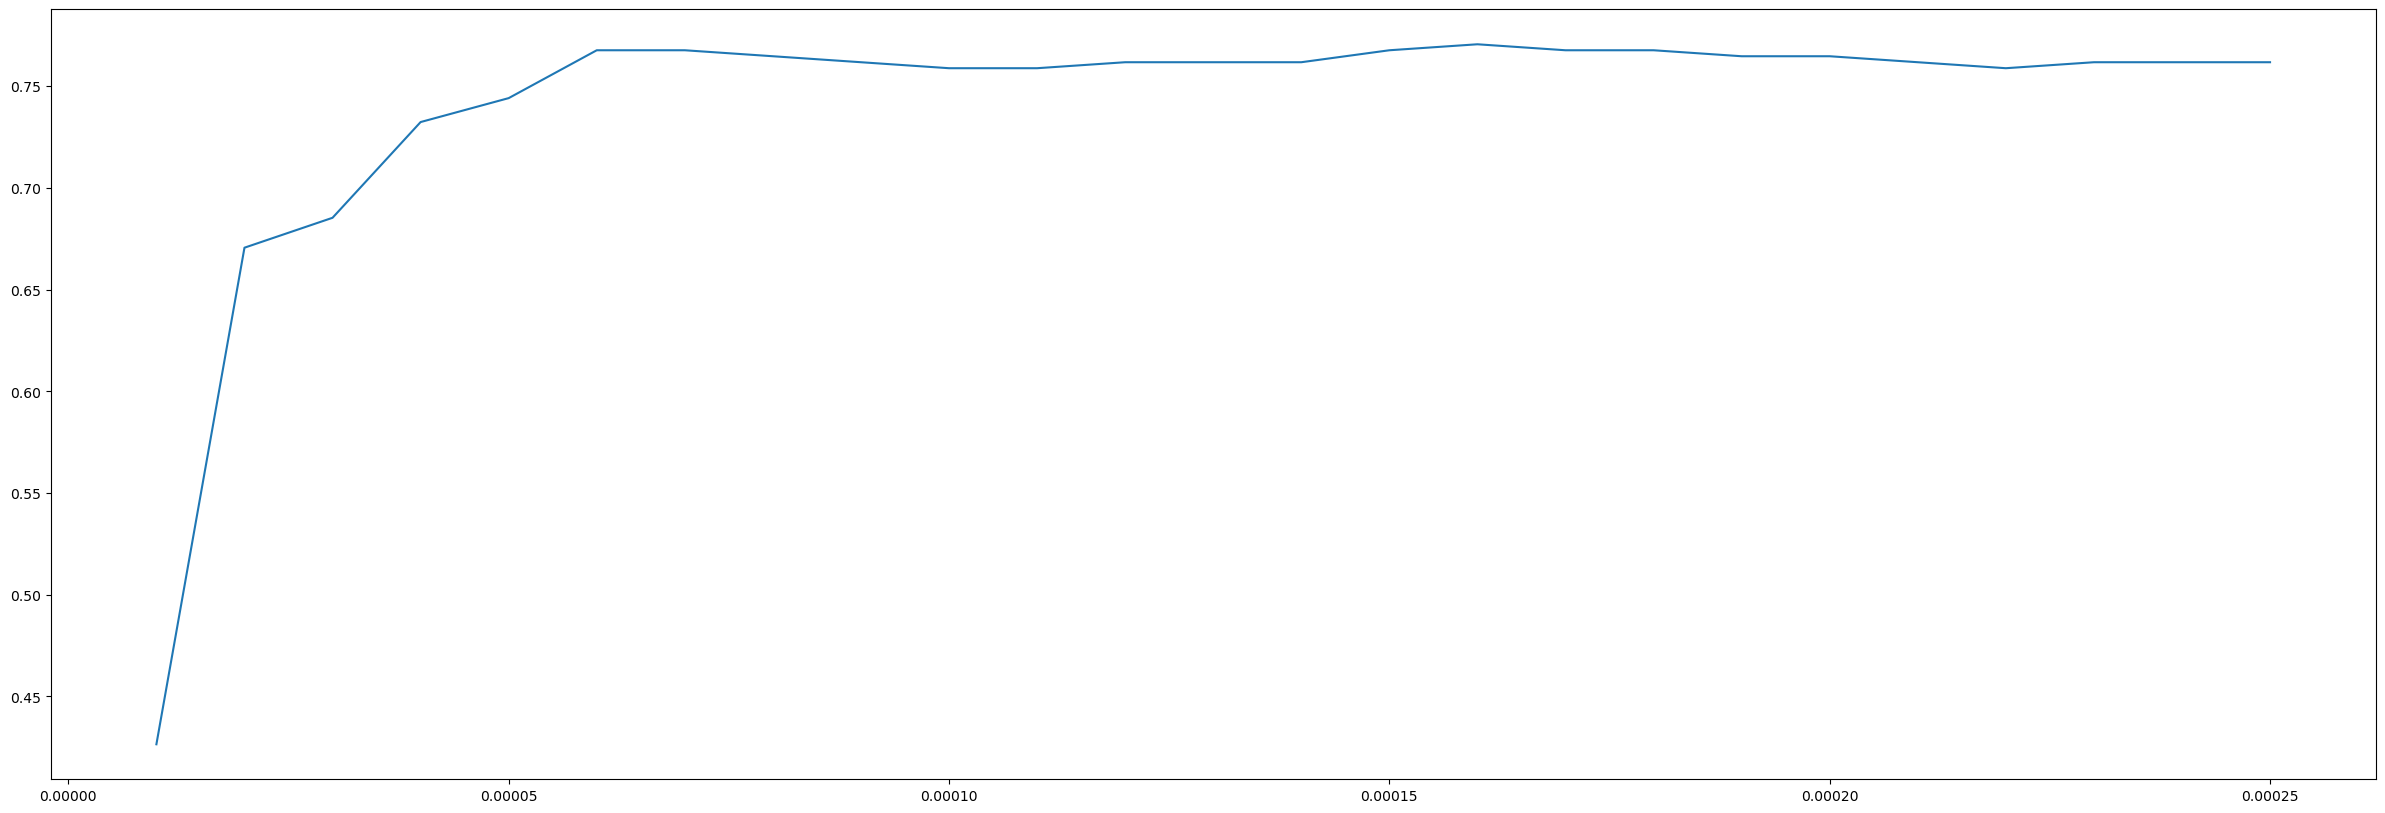

In [1809]:
scorel = []
for i in np.arange(0.00001, 0.00026, 0.00001):
    svm_2c8 = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, C=2, gamma=i)
    score = cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))))
plt.figure(figsize=[30,10])
plt.plot(np.arange(0.00001, 0.00026, 0.00001), scorel)
plt.show()

0.794392523364486 14


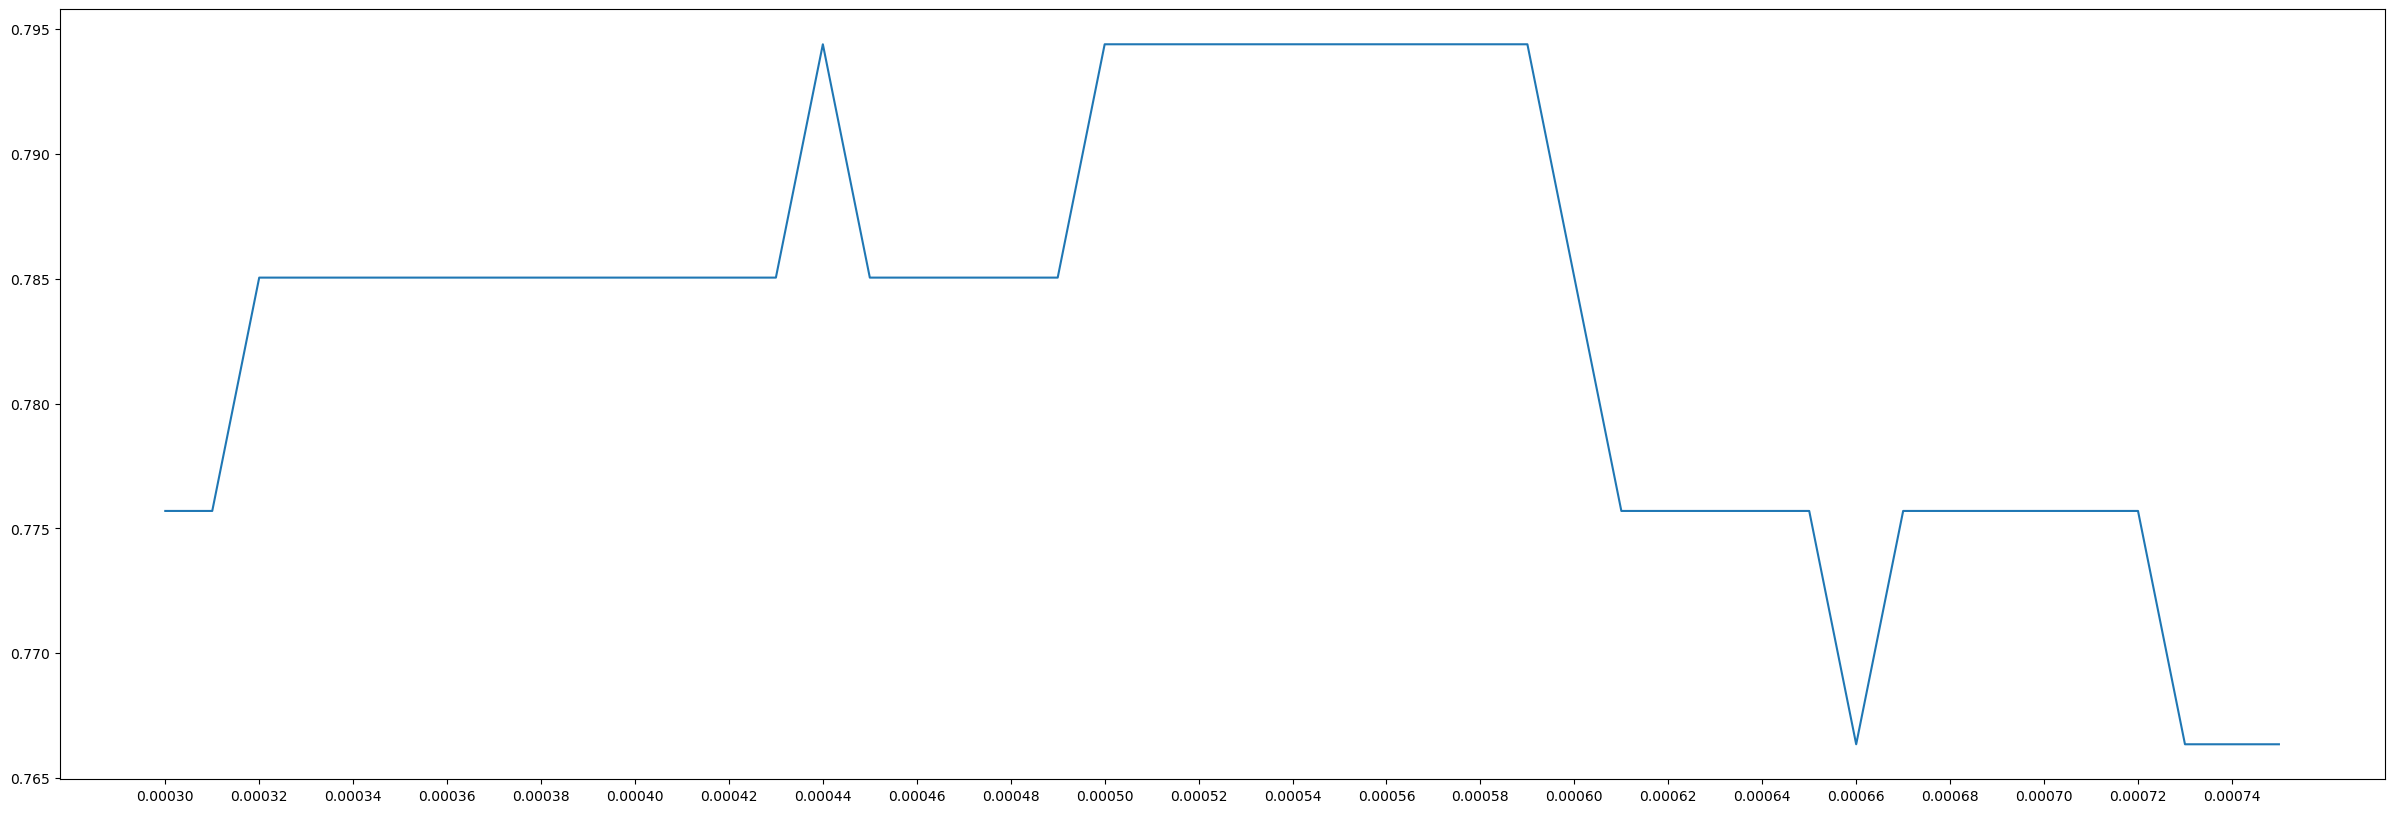

In [1815]:
scores = []
for i in np.arange(0.0003, 0.00076, 0.00001):
    svm_2c8 = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, C=2, gamma=i)
    svm_2c8.fit(x_train_scaled, y_train)
    y_pred = svm_2c8.predict(x_test_scaled)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
print(max(scores),(scores.index(max(scores))))
plt.figure(figsize=[30,10])
xticks = np.arange(0.0003, 0.00076, 0.00002)
plt.xticks(xticks)
plt.plot(np.arange(0.0003, 0.00076, 0.00001), scores)
plt.show()